## ***Main Implementation of the Proposed Technique*** 
#### *In this code, we execute the main script for adjusting activity durations.*
#### *Any event log that contains multitasking executions can be used as input to adjust the activity durations. As an example, we use the eventlog ['Consulta'](https://zenodo.org/records/5734443)*
#### *The event log XES file must contain the following attributes:*

`case:concept:name` | `concept:name` | `start:timestamp` | `time:timestamp` | `org:resource`

In [ ]:
# Import the libraries:
import numpy as np
import matplotlib.pyplot as plt
import time
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
import pytz
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from pm4py.objects.log.util import sorting
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

In [ ]:
# Loading the real_log
log = xes_importer.apply('E:/ACR/ACR_log.xes')
log

parsing log, completed traces ::   0%|          | 0/954 [00:00<?, ?it/s]

[{'attributes': {'concept:name': '81051'}, 'events': [{'concept:name': 'Bring student information - banner', 'start:timestamp': datetime.datetime(2016, 2, 1, 13, 23, 52, tzinfo=datetime.timezone.utc), 'time:timestamp': datetime.datetime(2016, 2, 1, 13, 23, 52, tzinfo=datetime.timezone.utc), 'org:resource': '8997'}, '..', {'concept:name': 'Homologation by course group', 'start:timestamp': datetime.datetime(2016, 2, 1, 21, 19, 41, tzinfo=datetime.timezone.utc), 'time:timestamp': datetime.datetime(2016, 2, 1, 21, 38, 15, tzinfo=datetime.timezone.utc), 'org:resource': '1007'}]}, '....', {'attributes': {'concept:name': '129262'}, 'events': [{'concept:name': 'Bring student information - banner', 'start:timestamp': datetime.datetime(2016, 6, 28, 15, 8, 14, tzinfo=datetime.timezone.utc), 'time:timestamp': datetime.datetime(2016, 6, 28, 15, 8, 14, tzinfo=datetime.timezone.utc), 'org:resource': '19692'}, '..', {'concept:name': 'Homologation by course group', 'start:timestamp': datetime.datetime(

In [ ]:
# Coverting event log xes file to dataframe
log_df = pm4py.convert_to_dataframe(log)
log_df.head(10)

,concept:name,start:timestamp,time:timestamp,org:resource,case:concept:name
0,Bring student information - banner,2016-02-01 13:23:52+00:00,2016-02-01 13:23:52+00:00,8997,81051
1,Submit Homologation Request,2016-02-01 13:24:02+00:00,2016-02-01 13:24:02+00:00,8997,81051
2,Validate request,2016-02-01 13:27:47+00:00,2016-02-01 13:32:06+00:00,387,81051
3,Homologation by course group,2016-02-01 21:19:41+00:00,2016-02-01 21:38:15+00:00,1007,81051
4,Bring student information - banner,2016-02-01 18:53:46+00:00,2016-02-01 18:53:46+00:00,6426,81102
5,Submit Homologation Request,2016-02-01 18:53:50+00:00,2016-02-01 19:09:56+00:00,6426,81102
6,Validate request,2016-02-03 19:47:36+00:00,2016-02-03 19:49:35+00:00,22475,81102
7,Homologation by course group,2016-02-03 22:59:19+00:00,2016-02-03 23:48:38+00:00,1343,81102
8,Bring student information - banner,2016-02-02 07:39:32+00:00,2016-02-02 07:39:32+00:00,8916,81201
9,Submit Homologation Request,2016-02-02 07:39:38+00:00,2016-02-02 07:55:38+00:00,8916,81201


#### ***Marking the workitems for overlapping execution and assigning an overlapping group identifier:***
*At this step, we identify whether each work item overlaps with another work item or executes individually. This condition is recorded in the column overlap, and the value is represented as a binary indicator (True or False). Furthermore, each group of overlapping work items is assigned a unique identifier, where '0' represents work items that do not overlap. We call this column as 'overlap_section'.*

In [ ]:
def mark_overlaps(
    log_df: pd.DataFrame,
    start_col: str = 'start:timestamp',
    end_col: str = 'time:timestamp',
    resource_col: str = 'org:resource',
    duration_sec_col: str = 'duration_seconds'  
) -> pd.DataFrame:
  
    df = log_df.copy()
    df[start_col] = pd.to_datetime(df[start_col])
    
   # initial values for columns
    df['overlap'] = False
    df['overlap_section'] = 0
    next_section_id = 1  #unique id for overlap sections across all resources

    #loop per resource.
    grouped = df.groupby(resource_col, sort=False)
    for resource, group in grouped:
         
        g = group.sort_values(start_col)
        indices = g.index.to_list()
        starts = g[start_col].values  
        ends = g[end_col].values
        n = len(indices)
        if n <= 1:
            continue  # no possible overlap for a single item

        # union-find (disjoint set) structure
        parent = list(range(n))
        def find(i):
            # pathcompression
            while parent[i] != i:
                parent[i] = parent[parent[i]]
                i = parent[i]
            return i
        def union(i, j):
            ri, rj = find(i), find(j)
            if ri != rj:
                parent[rj] = ri

        # compare intervals pairwise but break early using sorted starts:
        # for each i, only j with starts[j] < ends[i] can overlap i, so:
        for i in range(n):
            # j starts with i+1
            for j in range(i+1, n):
                # if start_j >= end_i then j and later cannot overlap i (sorted starts), so break
                if starts[j] >= ends[i]:
                    break
                # otherwise check overlap condition (strict)
                if (starts[i] < ends[j]) and (starts[j] < ends[i]):
                    union(i, j)

        # collect components
        components = {}
        for k in range(n):
            root = find(k)
            components.setdefault(root, []).append(k)

        # assign overlap flags/section ids for components with size > 1
        for comp in components.values():
            if len(comp) > 1:
                # assign a new global section id
                sid = next_section_id
                next_section_id += 1
                for k in comp:
                    df.at[indices[k], 'overlap'] = True
                    df.at[indices[k], 'overlap_section'] = sid
        # singletons remain overlap=False and overlap_section=0

    # return marked_df
    marked_df = df  # contains all original columns plus 'overlap' and 'overlap_section'
    return marked_df

marked_df = mark_overlaps(log_df)
marked_df.head(20)

,concept:name,start:timestamp,time:timestamp,org:resource,case:concept:name,overlap,overlap_section
0,Bring student information - banner,2016-02-01 13:23:52+00:00,2016-02-01 13:23:52+00:00,8997,81051,False,0
1,Submit Homologation Request,2016-02-01 13:24:02+00:00,2016-02-01 13:24:02+00:00,8997,81051,False,0
2,Validate request,2016-02-01 13:27:47+00:00,2016-02-01 13:32:06+00:00,387,81051,False,0
3,Homologation by course group,2016-02-01 21:19:41+00:00,2016-02-01 21:38:15+00:00,1007,81051,False,0
4,Bring student information - banner,2016-02-01 18:53:46+00:00,2016-02-01 18:53:46+00:00,6426,81102,False,0
5,Submit Homologation Request,2016-02-01 18:53:50+00:00,2016-02-01 19:09:56+00:00,6426,81102,False,0
6,Validate request,2016-02-03 19:47:36+00:00,2016-02-03 19:49:35+00:00,22475,81102,False,0
7,Homologation by course group,2016-02-03 22:59:19+00:00,2016-02-03 23:48:38+00:00,1343,81102,False,0
8,Bring student information - banner,2016-02-02 07:39:32+00:00,2016-02-02 07:39:32+00:00,8916,81201,False,0
9,Submit Homologation Request,2016-02-02 07:39:38+00:00,2016-02-02 07:55:38+00:00,8916,81201,False,0


In [ ]:
# Calculatng the duration in minutes:
marked_df['time:timestamp'] = pd.to_datetime(marked_df['time:timestamp'])
marked_df['start:timestamp'] = pd.to_datetime(marked_df['start:timestamp'])
marked_df['duration_minutes'] = (marked_df['time:timestamp'] - marked_df['start:timestamp']).dt.total_seconds() / 60


# Showing the table for:
# Activity | Average Activity Duration
average_duration = marked_df.groupby('concept:name')[['duration_minutes']].mean().reset_index()
average_duration

,concept:name,duration_minutes
0,Advance receipt of documents,136.426190
1,Approval Closing Process,30.306645
2,Bring student information - banner,0.000000
3,Cancel Request,55.395725
4,Cancel course,36.934127
5,Course evaluation,76.754360
6,Final validation,8.836710
7,Homologation by course group,120.284586
8,Receive documents,280.487681
9,Review course,27.169810


In [ ]:
#sort the column if needed:
marked_df = marked_df[['case:concept:name', 'concept:name', 'org:resource', 'start:timestamp', 'time:timestamp', 'duration_minutes', 
                       'overlap', 'overlap_section']]
marked_df.head(60)

,case:concept:name,concept:name,org:resource,start:timestamp,time:timestamp,duration_minutes,overlap,overlap_section
0,81051,Bring student information - banner,8997,2016-02-01 13:23:52+00:00,2016-02-01 13:23:52+00:00,0.000000,False,0
1,81051,Submit Homologation Request,8997,2016-02-01 13:24:02+00:00,2016-02-01 13:24:02+00:00,0.000000,False,0
2,81051,Validate request,387,2016-02-01 13:27:47+00:00,2016-02-01 13:32:06+00:00,4.316667,False,0
3,81051,Homologation by course group,1007,2016-02-01 21:19:41+00:00,2016-02-01 21:38:15+00:00,18.566667,False,0
4,81102,Bring student information - banner,6426,2016-02-01 18:53:46+00:00,2016-02-01 18:53:46+00:00,0.000000,False,0
5,81102,Submit Homologation Request,6426,2016-02-01 18:53:50+00:00,2016-02-01 19:09:56+00:00,16.100000,False,0
6,81102,Validate request,22475,2016-02-03 19:47:36+00:00,2016-02-03 19:49:35+00:00,1.983333,False,0
7,81102,Homologation by course group,1343,2016-02-03 22:59:19+00:00,2016-02-03 23:48:38+00:00,49.316667,False,0
8,81201,Bring student information - banner,8916,2016-02-02 07:39:32+00:00,2016-02-02 07:39:32+00:00,0.000000,False,0
9,81201,Submit Homologation Request,8916,2016-02-02 07:39:38+00:00,2016-02-02 07:55:38+00:00,16.000000,False,0


##### ***Computing the non-overlapping interval duration of multitasked workitems:***
*In this step, for each multitasked work item, we identify the intervals during which it executes individually. These intervals are marked as non_overlap_part and the interval duration is computed accordingly* 

In [ ]:
# Computing Non-Overlap part with the overlapping work item:

def compute_non_overlap(df, start_col='start:timestamp', end_col='time:timestamp'):
   
    df = df.copy()
    
    df[start_col] = pd.to_datetime(df[start_col], utc=True)
    df[end_col] = pd.to_datetime(df[end_col], utc=True)
    
    df['non_overlap_part'] = 0.0

    for section_id, group in df.groupby('overlap_section'):
        group = group.sort_values(start_col)
        
        # collect all unique time points
        times = pd.concat([group[start_col], group[end_col]]).drop_duplicates().sort_values().reset_index(drop=True)
        
        for i in range(len(times)-1):
            t0, t1 = times[i], times[i+1]
            slice_len = (t1 - t0).total_seconds() / 60.0  # in minutes
            if slice_len <= 0:
                continue
            
            # find active tasks in this slice
            active = group[(group[start_col] < t1) & (group[end_col] > t0)]
            
            if len(active) == 1:
                # this slice belongs entirely to this single task --so non-overlap
                idx = active.index[0]
                df.at[idx, 'non_overlap_part'] += slice_len
  
    return df

marked_df = compute_non_overlap(marked_df)
marked_df.head(20)

,case:concept:name,concept:name,org:resource,start:timestamp,time:timestamp,duration_minutes,overlap,overlap_section,non_overlap_part
0,81051,Bring student information - banner,8997,2016-02-01 13:23:52+00:00,2016-02-01 13:23:52+00:00,0.000000,False,0,0.000000
1,81051,Submit Homologation Request,8997,2016-02-01 13:24:02+00:00,2016-02-01 13:24:02+00:00,0.000000,False,0,0.000000
2,81051,Validate request,387,2016-02-01 13:27:47+00:00,2016-02-01 13:32:06+00:00,4.316667,False,0,4.316667
3,81051,Homologation by course group,1007,2016-02-01 21:19:41+00:00,2016-02-01 21:38:15+00:00,18.566667,False,0,18.566667
4,81102,Bring student information - banner,6426,2016-02-01 18:53:46+00:00,2016-02-01 18:53:46+00:00,0.000000,False,0,0.000000
5,81102,Submit Homologation Request,6426,2016-02-01 18:53:50+00:00,2016-02-01 19:09:56+00:00,16.100000,False,0,16.100000
6,81102,Validate request,22475,2016-02-03 19:47:36+00:00,2016-02-03 19:49:35+00:00,1.983333,False,0,0.000000
7,81102,Homologation by course group,1343,2016-02-03 22:59:19+00:00,2016-02-03 23:48:38+00:00,49.316667,False,0,32.683333
8,81201,Bring student information - banner,8916,2016-02-02 07:39:32+00:00,2016-02-02 07:39:32+00:00,0.000000,False,0,0.000000
9,81201,Submit Homologation Request,8916,2016-02-02 07:39:38+00:00,2016-02-02 07:55:38+00:00,16.000000,False,0,16.000000


##### ***Computing the activity average duration for use in the weighting factor:*** 
*We compute the average activity durations (weights) using KDE. For cases where no workitem of an activity is executed individually, we use the **non_overlap_part** durations within the multitasked workitems to compute the KDE; otherwise, in the worst-case scenario, we use the overall computed average duration.*

In [ ]:
# Computing Weights by KDE (Average duration of activities when occur independently 'with No-overlapping') :

from scipy.stats import gaussian_kde

def kde_mean(samples, n_samples=5000):
    samples = np.array(samples, dtype=float)
    samples = samples[~np.isnan(samples)]  #drop NaN if any
    
    # if no data
    if len(samples) == 0:
        return np.nan
    
    # if only one value (or all values equal)
    if len(samples) < 2 or np.allclose(samples, samples[0]):
        return float(np.mean(samples))
    
    # otherwise use KDE
    kde = gaussian_kde(samples)
    sampled = kde.resample(n_samples).flatten()
    return float(np.mean(sampled))

# 1. take only non-overlapping rows
no_overlap_df = marked_df[marked_df['overlap'] == False].copy()

# 2. group by activity and compute KDE-based average duration
result = (no_overlap_df
    .groupby('concept:name')['duration_minutes']
    .apply(lambda x: kde_mean(x.values))
    .reset_index(name='kde_avg_duration')
)

print(result)

                                 concept:name  kde_avg_duration
0                Advance receipt of documents        129.207645
1                    Approval Closing Process         27.598510
2          Bring student information - banner          0.000000
3                              Cancel Request         34.953308
4                               Cancel course          0.001265
5                           Course evaluation         72.962417
6                            Final validation          7.012358
7                Homologation by course group        100.911198
8                           Receive documents        358.030040
9                               Review course         19.033595
10  Student cancellation notification request          0.000000
11                Submit Homologation Request          5.333086
12                           Transfer credits          0.000000
13                  Transfer eligible credits          0.000000
14                           Validate re

In [ ]:
# Checking if any activity is missing:
all_activities = marked_df['concept:name'].unique()
missing_acts = set(all_activities) - set(result['concept:name'])
missing_acts

set()

In [ ]:
# Run the following block only if there are missing activities
if missing_acts:
    # Handling missing activities (if any)
    # using the non-overlap fragments inside overlapping sections ---

    fragments_df = (marked_df.groupby('concept:name')['non_overlap_part']
        .apply(lambda x: [v for v in x if v > 0])  # collect all fragments > 0
        .reset_index(name='fragments')
    )
    
    fragments_df['kde_avg_duration'] = fragments_df['fragments'].apply(kde_mean)
    fragments_df = fragments_df[['concept:name', 'kde_avg_duration']]
    
    # filter only the ones we actually need
    fragments_missing = fragments_df[fragments_df['concept:name'].isin(missing_acts)]
    
    #concate
    result = pd.concat([result, fragments_missing], ignore_index=True)
    
    #if still missing and resulted in nan then:
    for idx, row in result.iterrows():
        if pd.isna(row['kde_avg_duration']):
            act = row['concept:name']
            mean_val = marked_df.loc[marked_df['concept:name'] == act, 'duration_minutes'].mean()
            result.at[idx, 'kde_avg_duration'] = mean_val
result

In [ ]:
marked_df

##### ***Applying our technique (distributing overlap_duration proportionally with weighting factor):***
*After computing the non-overlapped activity average durations by KDE, we indentify the overlapping intervals within the multitasked workitems and distribute them proportionally according to the weighting factor.*

In [ ]:
## Computing Overlap Part and allocate it to multitasked work items as per the computed weights:

def allocate_overlap_durations(marked_df, kde_result,
                               start_col='start:timestamp',
                               end_col='time:timestamp'):
    
    df = marked_df.copy()

    df[start_col] = pd.to_datetime(df[start_col], utc=True)
    df[end_col] = pd.to_datetime(df[end_col], utc=True)

    # merge KDE mean values
    df = df.merge(kde_result, on='concept:name', how='left')

    # initialize allocation col.
    df['allocated_overlap_duration'] = 0.0
    df['total_overlap_part'] = 0.0

    # process each overlap_section separately (skip 0 = no overlap)
    for section_id, group in df.groupby('overlap_section'):
        if section_id == 0:
            continue

        group = group.sort_values(start_col)

        # collect all unique time points:
        times = pd.concat([group[start_col], group[end_col]]).drop_duplicates().sort_values().reset_index(drop=True)

        for i in range(len(times) - 1):
            t0, t1 = times[i], times[i + 1]
            slice_len = (t1 - t0).total_seconds() / 60.0  # in minutes
            if slice_len <= 0:
                continue

            active = group[(group[start_col] < t1) & (group[end_col] > t0)]
            if len(active) < 2:
                continue

            for idx in active.index:          
                df.at[idx, 'total_overlap_part'] += slice_len

            # get KDE weights
            weights = active['kde_avg_duration'].values.astype(float)
            total_w = weights.sum()
            if total_w <= 0:
                continue  # avoid division by zero

            # distribute slice length to active tasks
            for idx, w in zip(active.index, weights):
                share = slice_len * (w / total_w)
                df.at[idx, 'allocated_overlap_duration'] += share

    # compute final adjusted duration plus its non-overlapping part
    df['final_adjusted_duration'] = df['allocated_overlap_duration'] + df['non_overlap_part']
    return df

marked_df = allocate_overlap_durations(marked_df, result)

In [ ]:
# When there is no_overlapping -- there will be no change in durations occur:
mask_no_overlap = marked_df['overlap'] == False
marked_df.loc[mask_no_overlap, 'final_adjusted_duration'] = marked_df.loc[mask_no_overlap, 'duration_minutes']

In [ ]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

#Sorting the columns:
marked_df = marked_df[['case:concept:name', 'concept:name', 'org:resource', 'start:timestamp', 'time:timestamp', 'duration_minutes', 
                       'overlap', 'overlap_section', 'kde_avg_duration', 'non_overlap_part', 'total_overlap_part', 'allocated_overlap_duration',
                       'final_adjusted_duration']]

#### ***Showing the final dataframe with columns:***
- `case:concept:name` : case_id,
- `concept:name`     : activity,
- `org:resource`     : resource,
- `start:timestamp`  : start_time,
- `time:timestamp`   : end_time,
- `duration_minutes` : workitem execution duration,
- `overlap`          : whether workitem is multitasking or not (True or False),
- `overlap_section`  : identifier number for parallel executed workitems sharing their execution interval, 
- `kde_avg_duration` : non-overlapped average duration of activities, calculated by using KDE,
- `non_overlap_part` : non-overlap part with the multitasked workitem that executed all alone,
- `total_overlap_part` : the total interval duration during which the workitem overlaps with some other workitem(s),
- `allocated_overlap_duration` : overlap time allocated to workitem after distributing its total_overlap_part according to our proposed technique, 
- **`final_adjusted_duration`** : shows the final adjusted duration by summing the workitem's allocated_overlap_duration and non_overlap_part.

In [ ]:
marked_df.head(20)

,case:concept:name,concept:name,org:resource,start:timestamp,time:timestamp,duration_minutes,overlap,overlap_section,kde_avg_duration,non_overlap_part,total_overlap_part,allocated_overlap_duration,final_adjusted_duration
0,81051,Bring student information - banner,8997,2016-02-01 13:23:52+00:00,2016-02-01 13:23:52+00:00,0.00,False,0,0.00,0.00,0.00,0.00,0.00
1,81051,Submit Homologation Request,8997,2016-02-01 13:24:02+00:00,2016-02-01 13:24:02+00:00,0.00,False,0,5.33,0.00,0.00,0.00,0.00
2,81051,Validate request,387,2016-02-01 13:27:47+00:00,2016-02-01 13:32:06+00:00,4.32,False,0,22.16,4.32,0.00,0.00,4.32
3,81051,Homologation by course group,1007,2016-02-01 21:19:41+00:00,2016-02-01 21:38:15+00:00,18.57,False,0,100.91,18.57,0.00,0.00,18.57
4,81102,Bring student information - banner,6426,2016-02-01 18:53:46+00:00,2016-02-01 18:53:46+00:00,0.00,False,0,0.00,0.00,0.00,0.00,0.00
5,81102,Submit Homologation Request,6426,2016-02-01 18:53:50+00:00,2016-02-01 19:09:56+00:00,16.10,False,0,5.33,16.10,0.00,0.00,16.10
6,81102,Validate request,22475,2016-02-03 19:47:36+00:00,2016-02-03 19:49:35+00:00,1.98,False,0,22.16,0.00,0.00,0.00,1.98
7,81102,Homologation by course group,1343,2016-02-03 22:59:19+00:00,2016-02-03 23:48:38+00:00,49.32,False,0,100.91,32.68,0.00,0.00,49.32
8,81201,Bring student information - banner,8916,2016-02-02 07:39:32+00:00,2016-02-02 07:39:32+00:00,0.00,False,0,0.00,0.00,0.00,0.00,0.00
9,81201,Submit Homologation Request,8916,2016-02-02 07:39:38+00:00,2016-02-02 07:55:38+00:00,16.00,False,0,5.33,16.00,0.00,0.00,16.00


#### ***Graphical & Tabular Representation:***

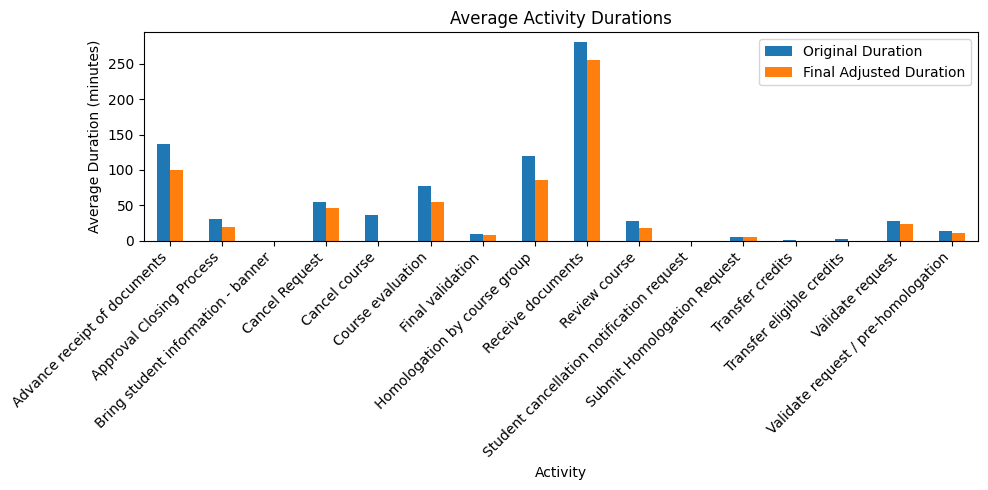

In [ ]:
# Group by activity and compute mean durations
avg_df = (marked_df
    .groupby('concept:name')[['duration_minutes', 'final_adjusted_duration']]
    .mean()
    .reset_index())

# Set activity names as index for plotting
avg_df.set_index('concept:name', inplace=True)

ax = avg_df.plot(kind='bar', figsize=(10, 5))

ax.set_xlabel('Activity')
ax.set_ylabel('Average Duration (minutes)')
ax.set_title('Average Activity Durations')
ax.legend(['Original Duration', 'Final Adjusted Duration'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
avg_table = (marked_df.groupby('concept:name')
    .agg(avg_duration_minutes=('duration_minutes', 'mean'),
        avg_final_adjusted_duration=('final_adjusted_duration', 'mean'))
    .reset_index())
avg_table

,concept:name,avg_duration_minutes,avg_final_adjusted_duration
0,Advance receipt of documents,136.43,99.51
1,Approval Closing Process,30.31,18.97
2,Bring student information - banner,0.00,0.00
3,Cancel Request,55.40,46.45
4,Cancel course,36.93,0.01
5,Course evaluation,76.75,55.38
6,Final validation,8.84,7.57
7,Homologation by course group,120.28,86.03
8,Receive documents,280.49,255.75
9,Review course,27.17,17.27
